In [1]:
import kagglehub
from pathlib import Path
import pandas as pd 
import numpy as np
import torch
import shap
from sklearn.metrics import classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import os
import gdown

In [14]:
path = kagglehub.dataset_download("columbine/imdb-dataset-sentiment-analysis-in-csv-format")
path = Path(path)
test_df = pd.read_csv(path / "Test.csv")
train_df = pd.read_csv(path / "Train.csv")
train_texts = train_df['text'].tolist()
train_labels = train_df['label'].tolist()
test_texts = test_df['text'].tolist()
test_labels = test_df['label'].tolist()
MAX_LEN = 256
train_df.head(5)

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [ ]:
from transformers import BertTokenizer, BertModel
from tqdm import tqdm
import numpy as np
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased', num_labels=2)
model.to(device)
model.eval()

BATCH_SIZE = 32

def get_embeddings_batch(texts_batch, model, tokenizer, device):
    """
    Generates BERT embeddings for a batch of texts.
    """
    inputs = tokenizer(
        texts_batch, 
        return_tensors='pt', 
        padding=True,
        truncation=True,
        max_length=256
    )
    
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs)
        
    cls_embeddings = outputs.last_hidden_state[:, 0, :]
    
    return cls_embeddings.cpu().detach().numpy()

all_embeddings_list = []

for i in tqdm(range(0, len(train_texts), BATCH_SIZE), desc="Embedding Train Batches"):
    batch_texts = train_texts[i:i+BATCH_SIZE]
    if batch_texts:
        batch_embeddings = get_embeddings_batch(batch_texts, model, tokenizer, device)
        all_embeddings_list.extend(batch_embeddings)


for i in tqdm(range(0, len(test_texts), BATCH_SIZE), desc="Embedding Test Batches"):
    batch_texts = test_texts[i:i+BATCH_SIZE]
    if batch_texts:
        batch_embeddings = get_embeddings_batch(batch_texts, model, tokenizer, device)
        all_embeddings_list.extend(batch_embeddings)

if all_embeddings_list:
    final_embeddings_array = np.array(all_embeddings_list)
    print(f"\nGenerated embeddings of shape: {final_embeddings_array.shape}")
    np.save('bert_embeddings.npy', final_embeddings_array)
    print("Embeddings saved to 'bert_embeddings.npy'")
else:
    print("\nNo embeddings were generated as DataFrames were empty, did not exist, or contained no 'text' data.")


In [5]:
def download_file_from_drive(file_id, output_path, file_description="file"):
    """
    Download a file from Google Drive using gdown
    
    Args:
        file_id (str): The Google Drive file ID
        output_path (str): Local path where the file should be saved
        file_description (str): Description of what the file is (for logging)
    """
    print(f"📥 Downloading {file_description}...")
    
    # Create directory if it doesn't exist (only if output_path has a directory)
    output_dir = os.path.dirname(output_path)
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
    
    # Construct the download URL
    url = f"https://drive.google.com/uc?id={file_id}"
    
    try:
        gdown.download(url, output_path, quiet=False)
        print(f"✅ Successfully downloaded {file_description} to {output_path}")
        return True
    except Exception as e:
        print(f"❌ Failed to download {file_description}: {str(e)}")
        return False
        

def main():
   """Main function to download all required files"""
print("🚀 Starting data download process...\n")
    
    
    # Download 1: BERT embeddings file
print("=" * 50)
if not os.path.exists('./bert_embeddings.npy'):
    embeddings_success = download_file_from_drive(
        file_id="17oE8ZaPSVt8mUFEBMqg_nEQKkqkBRpsp",
        output_path="./bert_embeddings.npy",
        file_description="BERT embeddings (bert_embeddings.npy)"
    )
else:
    embeddings_success = True

print()

🚀 Starting data download process...

📥 Downloading BERT embeddings (bert_embeddings.npy)...


Downloading...
From (original): https://drive.google.com/uc?id=17oE8ZaPSVt8mUFEBMqg_nEQKkqkBRpsp
From (redirected): https://drive.google.com/uc?id=17oE8ZaPSVt8mUFEBMqg_nEQKkqkBRpsp&confirm=t&uuid=9eb004e0-c067-4059-83b8-14d97101e1a2
To: /home/felipe-drummond/Insper/9_semestre/nlp/nlp_interpretability/bert_embeddings.npy
100%|██████████| 138M/138M [00:04<00:00, 33.3MB/s] 

✅ Successfully downloaded BERT embeddings (bert_embeddings.npy) to ./bert_embeddings.npy



Using device: cuda
Successfully loaded 'bert_embeddings.npy' with shape: (45000, 768)
Raw train embeddings shape: (40000, 768)
Raw test embeddings shape: (5000, 768)

Scaling features (embeddings)...
Feature scaling complete.

Created DataLoaders with batch size: 64

PyTorch MLP Model:
SentimentMLP(
  (fc1): Linear(in_features=768, out_features=32, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)

Starting training for 25 epochs...
Epoch [1/25], Train Acc: 80.16%, Val Acc: 84.22%
Epoch [2/25], Train Acc: 83.67%, Val Acc: 84.78%
Epoch [3/25], Train Acc: 84.28%, Val Acc: 85.08%
Epoch [4/25], Train Acc: 84.64%, Val Acc: 85.02%
Epoch [5/25], Train Acc: 84.97%, Val Acc: 85.28%
Epoch [6/25], Train Acc: 85.21%, Val Acc: 85.14%
Epoch [7/25], Train Acc: 85.40%, Val Acc: 85.56%
Epoch [8/25], 

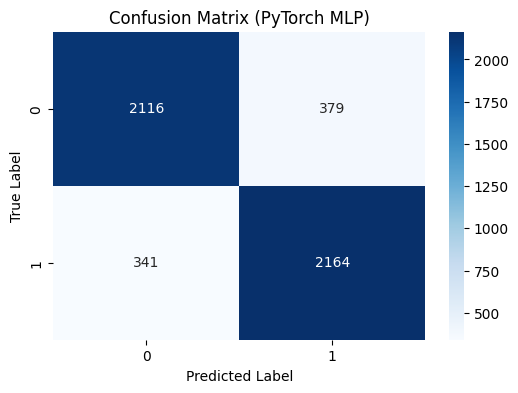

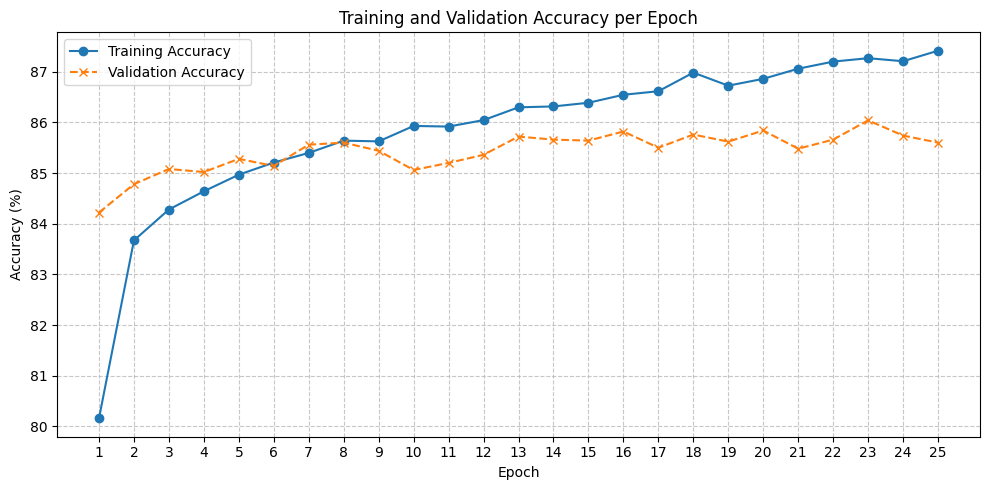


--- PyTorch MLP Classification Example End ---


In [6]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler # To ensure we have scaled embeddings
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

all_embeddings = np.load('bert_embeddings.npy')
print(f"Successfully loaded 'bert_embeddings.npy' with shape: {all_embeddings.shape}")


num_train_samples = len(train_df)
train_embeddings_np = all_embeddings[:num_train_samples]
test_embeddings_np = all_embeddings[num_train_samples:]
train_labels_np = train_df['label'].values
test_labels_np = test_df['label'].values

if train_embeddings_np.shape[0] != train_labels_np.shape[0] or \
   test_embeddings_np.shape[0] != test_labels_np.shape[0] or \
   train_embeddings_np.shape[0] == 0 or test_embeddings_np.shape[0] == 0:
    print("Error: Mismatch in data shapes or empty data. Check data preparation.")
    exit()
    
print(f"Raw train embeddings shape: {train_embeddings_np.shape}")
print(f"Raw test embeddings shape: {test_embeddings_np.shape}")

print("\nScaling features (embeddings)...")
scaler = StandardScaler()
train_embeddings_scaled_np = scaler.fit_transform(train_embeddings_np)
test_embeddings_scaled_np = scaler.transform(test_embeddings_np)
print("Feature scaling complete.")

X_train_tensor = torch.tensor(train_embeddings_scaled_np, dtype=torch.float32)
y_train_tensor = torch.tensor(train_labels_np, dtype=torch.long)
X_test_tensor = torch.tensor(test_embeddings_scaled_np, dtype=torch.float32)
y_test_tensor = torch.tensor(test_labels_np, dtype=torch.long)

BATCH_SIZE = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
print(f"\nCreated DataLoaders with batch size: {BATCH_SIZE}")

class SentimentMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim, dropout_rate=0.5):
        super(SentimentMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(hidden_dim2, output_dim)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        out = self.fc3(out)
        return out

INPUT_DIM = X_train_tensor.shape[1]
HIDDEN_DIM1 = 32
HIDDEN_DIM2 = 16
OUTPUT_DIM = 2
DROPOUT_RATE = 0.5
model = SentimentMLP(INPUT_DIM, HIDDEN_DIM1, HIDDEN_DIM2, OUTPUT_DIM, DROPOUT_RATE).to(device)
print("\nPyTorch MLP Model:")
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

NUM_EPOCHS = 25
train_accuracies = []
val_accuracies = [] 

print(f"\nStarting training for {NUM_EPOCHS} epochs...")
for epoch in range(NUM_EPOCHS):
    model.train() 
    epoch_train_correct = 0
    epoch_train_total = 0

    for i, (embeddings_batch, labels_batch) in enumerate(train_loader):
        embeddings_batch = embeddings_batch.to(device)
        labels_batch = labels_batch.to(device)

        optimizer.zero_grad()
        outputs = model(embeddings_batch)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()

        
        _, predicted_train = torch.max(outputs.data, 1)
        epoch_train_total += labels_batch.size(0)
        epoch_train_correct += (predicted_train == labels_batch).sum().item()

    
    current_epoch_train_accuracy = 100 * epoch_train_correct / epoch_train_total
    train_accuracies.append(current_epoch_train_accuracy)
    
    model.eval() 
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for embeddings_batch, labels_batch in test_loader: 
            embeddings_batch = embeddings_batch.to(device)
            labels_batch = labels_batch.to(device)
            outputs = model(embeddings_batch)
            _, predicted_val = torch.max(outputs.data, 1)
            val_total += labels_batch.size(0)
            val_correct += (predicted_val == labels_batch).sum().item()
    
    current_epoch_val_accuracy = 100 * val_correct / val_total
    val_accuracies.append(current_epoch_val_accuracy)
    
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Train Acc: {current_epoch_train_accuracy:.2f}%, Val Acc: {current_epoch_val_accuracy:.2f}%")


print("Training finished.")

model.eval() 
all_preds = []
all_labels = []

with torch.no_grad():
    for embeddings_batch, labels_batch in test_loader:
        embeddings_batch = embeddings_batch.to(device)
        labels_batch = labels_batch.to(device)
        outputs = model(embeddings_batch)
        _, predicted_classes = torch.max(outputs.data, 1)
        all_preds.extend(predicted_classes.cpu().numpy())
        all_labels.extend(labels_batch.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"\nTest Accuracy (PyTorch MLP): {accuracy:.4f}")
print("\nClassification Report (PyTorch MLP):")
print(classification_report(all_labels, all_preds))
print("\nConfusion Matrix (PyTorch MLP):")
cm = confusion_matrix(all_labels, all_preds)
print(cm)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (PyTorch MLP)')
plt.show()

# Plot training and validation ACCURACY
plt.figure(figsize=(10,5))
plt.plot(range(1, NUM_EPOCHS + 1), train_accuracies, marker='o', linestyle='-', label='Training Accuracy')
plt.plot(range(1, NUM_EPOCHS + 1), val_accuracies, marker='x', linestyle='--', label='Validation Accuracy')
plt.title("Training and Validation Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.xticks(range(1, NUM_EPOCHS + 1))
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

print("\n--- PyTorch MLP Classification Example End ---")


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW

from tqdm.notebook import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
model.to(device)
print(f"Loaded {MODEL_NAME} for sequence classification.")


print(f"Loaded {len(train_texts)} training texts and {len(test_texts)} testing texts.")
print(f"Example train text: '{train_texts[0]}' with label: {train_labels[0]}")
print(f"Unique labels in training data: {np.unique(train_labels)}")
print(f"Unique labels in testing data: {np.unique(test_labels)}")

class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

MAX_LEN = 256
BATCH_SIZE = 16

train_dataset = SentimentDataset(train_texts, train_labels, tokenizer, MAX_LEN)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_dataset = SentimentDataset(test_texts, test_labels, tokenizer, MAX_LEN)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"\nCreated DataLoaders with batch size: {BATCH_SIZE} and max_len: {MAX_LEN}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of testing batches: {len(test_loader)}")

optimizer = AdamW(
    model.parameters(),
    lr=2e-5,
    eps=1e-8,
    weight_decay=0.01
)

NUM_EPOCHS = 4
total_steps = len(train_loader) * NUM_EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

print(f"\nStarting fine-tuning for {NUM_EPOCHS} epochs...")

for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_train_loss = 0
    epoch_train_correct = 0
    epoch_train_total = 0
    progress_bar_train = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Training]", leave=False, unit="batch")

    for batch in progress_bar_train:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        loss = outputs.loss
        logits = outputs.logits
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        epoch_train_loss += loss.item()
        _, predicted_train = torch.max(logits, 1)
        epoch_train_total += labels.size(0)
        epoch_train_correct += (predicted_train == labels).sum().item()
        progress_bar_train.set_postfix({'loss': loss.item(), 'acc': (predicted_train == labels).sum().item()/labels.size(0)})

    avg_train_loss = epoch_train_loss / len(train_loader)
    current_epoch_train_accuracy = 100 * epoch_train_correct / epoch_train_total
    train_losses.append(avg_train_loss)
    train_accuracies.append(current_epoch_train_accuracy)

    model.eval()
    epoch_val_loss = 0
    val_correct = 0
    val_total = 0
    progress_bar_val = tqdm(test_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Validation]", leave=False, unit="batch")
    with torch.no_grad():
        for batch in progress_bar_val:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss
            logits = outputs.logits
            epoch_val_loss += loss.item()
            _, predicted_val = torch.max(logits, 1)
            val_total += labels.size(0)
            val_correct += (predicted_val == labels).sum().item()
            progress_bar_val.set_postfix({'val_loss': loss.item(), 'val_acc': (predicted_val == labels).sum().item()/labels.size(0)})

    avg_val_loss = epoch_val_loss / len(test_loader)
    current_epoch_val_accuracy = 100 * val_correct / val_total
    val_losses.append(avg_val_loss)
    val_accuracies.append(current_epoch_val_accuracy)

    print(f"\nEpoch [{epoch+1}/{NUM_EPOCHS}] Summary:")
    print(f"  Train Loss: {avg_train_loss:.4f}, Train Acc: {current_epoch_train_accuracy:.2f}%")
    print(f"  Val Loss  : {avg_val_loss:.4f}, Val Acc  : {current_epoch_val_accuracy:.2f}%")

print("\nFine-tuning finished.")

model.eval()
all_preds = []
all_labels = []
print("\nEvaluating on the test set...")
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating", unit="batch"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        logits = outputs.logits
        _, predicted_classes = torch.max(logits, 1)
        all_preds.extend(predicted_classes.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"\nTest Accuracy (Fine-tuned BERT): {accuracy:.4f}")
print("\nClassification Report (Fine-tuned BERT):")
print(classification_report(all_labels, all_preds, target_names=[f'Class {i}' for i in range(model.config.num_labels)], zero_division=0))
print("\nConfusion Matrix (Fine-tuned BERT):")
cm = confusion_matrix(all_labels, all_preds)
print(cm)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f'Pred Class {i}' for i in range(model.config.num_labels)],
            yticklabels=[f'True Class {i}' for i in range(model.config.num_labels)])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Fine-tuned BERT)')
plt.show()

epochs_range = range(1, NUM_EPOCHS + 1)
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accuracies, marker='o', linestyle='-', label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, marker='x', linestyle='--', label='Validation Accuracy')
plt.title("Training & Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.xticks(epochs_range)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_losses, marker='o', linestyle='-', label='Training Loss')
plt.plot(epochs_range, val_losses, marker='x', linestyle='--', label='Validation Loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(epochs_range)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='best')

plt.tight_layout()
plt.show()

print("\n--- BERT Fine-tuning Example End ---")

# Optional: Save fine-tuned model
output_dir = './bert_sentiment_finetuned/'
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"Fine-tuned model and tokenizer saved to {output_dir}")

In [8]:
#!/usr/bin/env python3
"""
Script to download required data files from Google Drive
"""

import os
import gdown
from pathlib import Path

def download_file_from_drive(file_id, output_path, file_description="file"):
    """
    Download a file from Google Drive using gdown
    
    Args:
        file_id (str): The Google Drive file ID
        output_path (str): Local path where the file should be saved
        file_description (str): Description of what the file is (for logging)
    """
    print(f"📥 Downloading {file_description}...")
    
    # Create directory if it doesn't exist (only if output_path has a directory)
    output_dir = os.path.dirname(output_path)
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
    
    # Construct the download URL
    url = f"https://drive.google.com/uc?id={file_id}"
    
    try:
        gdown.download(url, output_path, quiet=False)
        print(f"✅ Successfully downloaded {file_description} to {output_path}")
        return True
    except Exception as e:
        print(f"❌ Failed to download {file_description}: {str(e)}")
        return False

def download_folder_from_drive(folder_id, output_dir, folder_description="folder"):
    """
    Download a folder from Google Drive using gdown
    
    Args:
        folder_id (str): The Google Drive folder ID
        output_dir (str): Local directory where the folder should be saved
        folder_description (str): Description of what the folder is (for logging)
    """
    print(f"📁 Downloading {folder_description}...")
    
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Construct the folder URL
    folder_url = f"https://drive.google.com/drive/folders/{folder_id}"
    
    try:
        # Try to download the entire folder
        gdown.download_folder(folder_url, output=output_dir, quiet=False, use_cookies=False)
        print(f"✅ Successfully downloaded {folder_description} to {output_dir}")
        return True
    except Exception as e:
        print(f"❌ Failed to download {folder_description} using folder method: {str(e)}")
        print("🔄 Trying alternative download method...")
        
        # Alternative: Try to download folder as zip
        try:
            zip_url = f"https://drive.google.com/uc?id={folder_id}&export=download"
            zip_path = os.path.join(output_dir, f"{folder_description}.zip")
            gdown.download(zip_url, zip_path, quiet=False)
            print(f"✅ Downloaded {folder_description} as zip to {zip_path}")
            print("📦 You may need to extract the zip file manually")
            return True
        except Exception as zip_error:
            print(f"❌ Alternative download also failed: {str(zip_error)}")
            return False

def main():
    
    # Download 2: BERT sentiment model folder
    print("=" * 50)
    model_success = False
    if not os.path.exists('./bert_sentiment_finetuned'):
        model_success = download_folder_from_drive(
            folder_id="17PAL9J3eRcx360mxC9IoP6jBYzHdRIsl",
            output_dir="./bert_sentiment_finetuned",
            folder_description="BERT sentiment model"
        )
    if model_success:
        print(f"📁 Files saved in project root: {os.path.abspath('.')}")
        
        # List downloaded files in project root
        print("\n📋 Downloaded files/folders:")
        for item in os.listdir('.'):
            if os.path.isfile(item) and (item.endswith('.npy') or item.endswith('.zip')):
                file_size = os.path.getsize(item) / (1024*1024)  # Size in MB
                print(f"  📄 {item} ({file_size:.2f} MB)")
            elif os.path.isdir(item) and item.startswith('bert_'):
                print(f"  📁 {item}/ (folder)")
                # List contents of the folder
                try:
                    for subitem in os.listdir(item):
                        subpath = os.path.join(item, subitem)
                        if os.path.isfile(subpath):
                            subsize = os.path.getsize(subpath) / (1024*1024)
                            print(f"    - {subitem} ({subsize:.2f} MB)")
                except:
                    pass
    else:
        print("❌ Some downloads failed. Please check your internet connection and file permissions.")

if __name__ == "__main__":
    main() 

❌ Some downloads failed. Please check your internet connection and file permissions.


In [15]:
import shap
import numpy as np
import torch
import pandas as pd
from tqdm.notebook import tqdm

from transformers import BertForSequenceClassification, BertTokenizer

# Load the saved model and tokenizer
model = BertForSequenceClassification.from_pretrained('./bert_sentiment_finetuned')
tokenizer = BertTokenizer.from_pretrained('./bert_sentiment_finetuned')

model.eval()
model.to(device)
print(f"Model is on device: {device} and in evaluation mode.")

def f(texts):
    if isinstance(texts, np.ndarray):
        texts = texts.tolist()
    if not isinstance(texts, list):
        texts = [texts]

    inputs = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=MAX_LEN,
        return_tensors="pt"
    )
    
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
    
    probabilities = torch.softmax(logits, dim=-1)
    
    return probabilities.cpu().numpy()

num_background_samples = min(50, len(train_texts))
background_data = np.array(train_texts[:num_background_samples])
print(f"Using {len(background_data)} samples from train_texts as background data for SHAP.")



print("\nInitializing SHAP Explainer...")
explainer = shap.Explainer(f, tokenizer, output_names=['Negative', 'Positive'])

num_examples_to_explain = 5
texts_to_explain = test_texts[:num_examples_to_explain]
labels_for_texts = test_labels[:num_examples_to_explain]
print(f"Preparing to explain {len(texts_to_explain)} instances from the test set.")

print("\nCalculating SHAP values for selected instances...")
print("This might take a while depending on the number of instances and MAX_LEN.")

shap_values = explainer(np.array(texts_to_explain))

print("SHAP values calculated.")

print(f"\nSHAP explainer output names: {shap_values.output_names}")

positive_class_index = 1
if shap_values.output_names:
    try:
        positive_class_index = shap_values.output_names.index('Positive')
    except ValueError:
        print("Warning: 'Positive' not in output_names. Defaulting to index 1 for visualization.")

print(f"\n--- Visualizing SHAP Explanations for '{shap_values.output_names[positive_class_index] if shap_values.output_names else 'Class 1'}' ---")

predicted_probs = f(texts_to_explain)
predicted_classes = np.argmax(predicted_probs, axis=1)

for i in range(len(texts_to_explain)):
    print(f"\nInstance {i+1}:")
    print(f"Text: \"{texts_to_explain[i]}\"")
    print(f"Actual Label: {'Positive' if labels_for_texts[i] == 1 else 'Negative'} (Raw: {labels_for_texts[i]})")
    print(f"Predicted Label: {'Positive' if predicted_classes[i] == 1 else 'Negative'} (Raw: {predicted_classes[i]}), Probability: {predicted_probs[i][predicted_classes[i]]:.4f}")
    
    
    shap.plots.text(shap_values[i, :, positive_class_index])
    


print("\n--- SHAP Explanation Cell End ---")

Model is on device: cuda and in evaluation mode.
Using 50 samples from train_texts as background data for SHAP.

Initializing SHAP Explainer...
Preparing to explain 5 instances from the test set.

Calculating SHAP values for selected instances...
This might take a while depending on the number of instances and MAX_LEN.


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██        | 1/5 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 3/5 [01:01<00:24, 12.14s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 4/5 [01:26<00:17, 17.62s/it]Token indices sequence length is longer than the specified maximum sequence length for this model (1018 > 512). Running this sequence through the model will result in indexing errors


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 5/5 [02:00<00:00, 23.64s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 6it [02:25, 29.03s/it]                       


SHAP values calculated.

SHAP explainer output names: [np.str_('Negative'), np.str_('Positive')]

--- Visualizing SHAP Explanations for 'Positive' ---

Instance 1:
Text: "I always wrote this series off as being a complete stink-fest because Jim Belushi was involved in it, and heavily. But then one day a tragic happenstance occurred. After a White Sox game ended I realized that the remote was all the way on the other side of the room somehow. Now I could have just gotten up and walked across the room to get the remote, or even to the TV to turn the channel. But then why not just get up and walk across the country to watch TV in another state? "Nuts to that", I said. So I decided to just hang tight on the couch and take whatever Fate had in store for me. What Fate had in store was an episode of this show, an episode about which I remember very little except that I had once again made a very broad, general sweeping blanket judgment based on zero objective or experiential evidence with not


Instance 2:
Text: "1st watched 12/7/2002 - 3 out of 10(Dir-Steve Purcell): Typical Mary Kate & Ashley fare with a few more kisses. It looks to me like the girls are getting pretty tired of this stuff and it will be interesting what happens to them if they ever decide to split up and go there own ways. In this episode of their adventures they are interns in Rome for a `fashion' designer who puts them right into the mailroom to learn what working hard is all about(I guess..). Besides the typical flirtations with boys there is nothing much else except the Rome scenario until about ¾ way into the movie when it's finally revealed why they are getting fired, then re-hired, then fired again, then re-hired again. This is definetly made by people who don't understand the corporate world and it shows in their interpretation of it. Maybe the real world will be their next adventure(if there is one.). Even my kids didn't seem to care for this boring `adventure' in the make-believe. Let's see they 


Instance 3:
Text: "This movie was so poorly written and directed I fell asleep 30 minutes through the movie. The jokes in the movie are corny and even though the plot is interesting at some angles, it is too far fetched and at some points- ridiculous. If you are 11 or older you will overlook the writing in the movie and be disappointed, but if you are 10 or younger this is a film that will capture your attention and be amazed with all the stunts (which I might add are poorly done) and wish you were some warrior to. The casting in this movie wasn't very good, and the music was very disappointing because it was like they were trying to build up the tension but it didn't fit at all. On a scale of 1-10 (10 being excellent, 1 being horrible) the acting in this movie is a 4. Brenda Song is talented in comedy, but with this kind of movie, in some of the more serious scenes, her acting was laughable. When she made some of her "fighting" poses, I started laughing out loud. I think the worst th


Instance 4:
Text: "The most interesting thing about Miryang (Secret Sunshine) is the actors. Jeon Do-yeon, as Lee Shin-ae, the main character, is a woman with a young son whose husband has died in a tragic accident, and who leaves Seoul to live in Miryang, which was his home town, with her young son. Jeon's face is very changeable. She is girlish, flirtatious, elegant, aged and sad, desperate and joyous, with it and terribly isolated by turns, and it's all in her face. The film also stars Song Kang-ho as Kim, a man who meets her when her car breaks down coming into Miryang, who happens to run a garage in town, and who follows her around all the time thereafter, despite her apparent lack of interest in his attentions. Song is the biggest star in Korea right now, renowned for his work with Park Chan-wook and Bong Joon-ho (Sympathy for Mr. Vengeance; Memories of Murder and The Host). And yet here he plays a throwaway character, almost a forgotten man. But of course he makes him interesti


Instance 5:
Text: "when i first read about "berlin am meer" i didn't expect much. but i thought with the right people, the right locations, the right music and fashion you could at least make a trivial movie about the hip berlin everyone seems to be talking about. but eissler failed, it's so ridiculously unauthentic. it's a complete misrepresentation of what it is going on in berlin's so called scene. of course it's not all about hippness, but you should expect more from a movie that's being sold as "the definite berlin movie".<br /><br />and apart from all the credibility stuff, it really is a bad movie. mediocre acting and a rather boring plot. interestingly some of the actors have proved in other movies that they are actually quite talented. so it really must be poor directing skills.<br /><br />don't bother watching "berlin am meer" unless you are 17, come from some small town in western Germany and want to move to the big city after you finished school. then you might actually fi


--- SHAP Explanation Cell End ---


=== Quantitative Explanation Quality Analysis ===
Extracted 2296 tokens for analysis
Sample tokens: ['i', 'always', 'wrote', 'this', 'series', 'off', 'as', 'being', 'a', 'complete']
Sample SHAP scores: [np.float64(-0.00023125301292745105), np.float64(-0.00023125301292745105), np.float64(-0.00023125301292745105), np.float64(-0.00023125301292745105), np.float64(-0.015591559975902752), np.float64(-0.015591559975902752), np.float64(-0.014435682490031437), np.float64(-0.014435682490031437), np.float64(-0.004485960541750719), np.float64(-0.004485960541750719)]

1. Sentiment-Attribution Alignment Score (SAAS): -0.1096
   (Range: -1 to 1, higher is better. >0 means attributions align with sentiment)

2. Attribution Entropy (AE): 4.2755
   (Lower values indicate more focused explanations)
   Individual entropies: ['5.089', '4.159', '4.315', '3.259', '4.555']

3. Explanation Consistency Index (ECI): 0.0000
   (Range: 0 to 1, higher is better)
   Found 10 similar text pairs for comparison

4. Pro

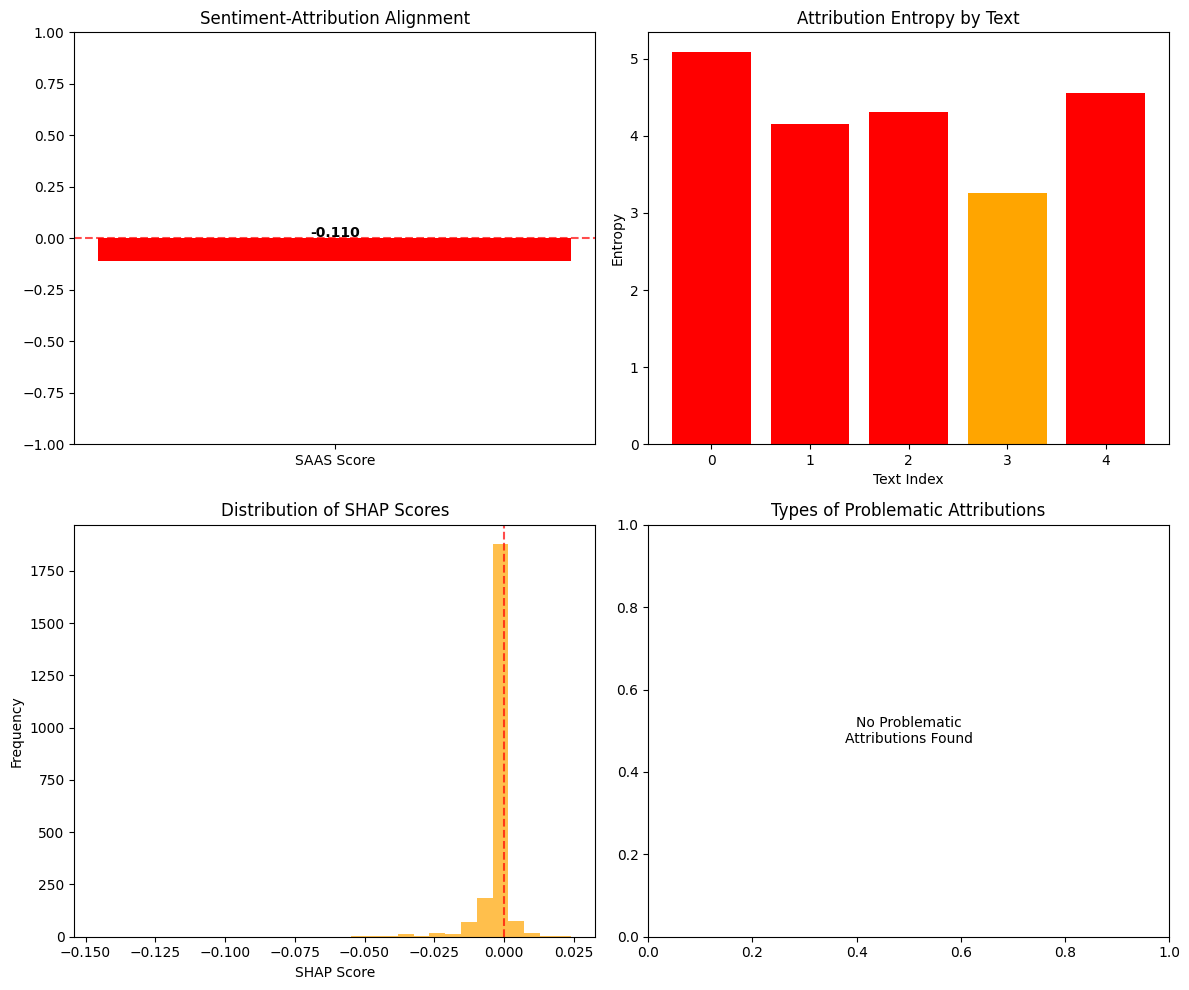


=== OVERFITTING-EXPLANATION CORRELATION ===
Baseline Model - Overfitting Gap: 0.020
Fine-tuned Model - Overfitting Gap: 0.055
Current Model SAAS Score: -0.1096
Current Model Mean Entropy: 4.2755

🔍 KEY EVIDENCE OF OVERFITTING IMPACT:
• Fine-tuned model has 2.7x larger overfitting gap
• SAAS score of -0.110 indicates explanations contradict sentiment intuition
• High entropy (4.3) shows scattered, unfocused explanations
• Found 0 counterintuitive word attributions

=== Analysis Complete ===

Results saved to results_summary dictionary
Use these metrics to compare explanation quality across different models!


In [17]:
# Fixed Quantitative Explanation Quality Metrics Analysis
import numpy as np
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr, entropy
import matplotlib.pyplot as plt
import seaborn as sns

print("=== Quantitative Explanation Quality Analysis ===")

analyzer = SentimentIntensityAnalyzer()

def extract_tokens_and_shap(shap_values, texts, tokenizer):
    """Extract tokens and their corresponding SHAP values"""
    all_tokens = []
    all_shap_scores = []
    all_text_indices = []
    
    for i, text in enumerate(texts):
        tokens = tokenizer.tokenize(text)
        
        shap_scores = shap_values[i, :len(tokens), 1].values
        
        all_tokens.extend(tokens)
        all_shap_scores.extend(shap_scores)
        all_text_indices.extend([i] * len(tokens))
    
    return all_tokens, all_shap_scores, all_text_indices

tokens, shap_scores, text_indices = extract_tokens_and_shap(shap_values, texts_to_explain, tokenizer)

print(f"Extracted {len(tokens)} tokens for analysis")
print(f"Sample tokens: {tokens[:10]}")
print(f"Sample SHAP scores: {shap_scores[:10]}")

def calculate_saas(tokens, shap_scores):
    """Calculate Sentiment-Attribution Alignment Score"""
    alignment_scores = []
    
    for token, shap_score in zip(tokens, shap_scores):
        if token.startswith('##') or token in ['[CLS]', '[SEP]', '[PAD]']:
            continue
        
        sentiment_result = analyzer.polarity_scores(token)
        compound_score = sentiment_result['compound']
        
        if compound_score > 0.1:
            sentiment_polarity = 1 
        elif compound_score < -0.1:
            sentiment_polarity = -1 
        else:
            continue 
        
        shap_sign = 1 if shap_score > 0 else -1
        alignment = shap_sign * sentiment_polarity
        alignment_scores.append(alignment)
    
    return np.mean(alignment_scores) if alignment_scores else 0

saas_score = calculate_saas(tokens, shap_scores)
print(f"\n1. Sentiment-Attribution Alignment Score (SAAS): {saas_score:.4f}")
print(f"   (Range: -1 to 1, higher is better. >0 means attributions align with sentiment)")

def calculate_attribution_entropy(shap_scores_by_text):
    """Calculate Attribution Entropy for each text"""
    entropies = []
    
    for shap_vals in shap_scores_by_text:
        abs_vals = np.abs(shap_vals)
        if np.sum(abs_vals) == 0:
            entropies.append(0)
            continue
        
        probs = abs_vals / np.sum(abs_vals)
        ent = entropy(probs + 1e-10)
        entropies.append(ent)
    
    return entropies

shap_by_text = []
for i in range(len(texts_to_explain)):
    text_shap = [score for score, text_idx in zip(shap_scores, text_indices) if text_idx == i]
    shap_by_text.append(text_shap)

entropies = calculate_attribution_entropy(shap_by_text)
mean_entropy = np.mean(entropies)

print(f"\n2. Attribution Entropy (AE): {mean_entropy:.4f}")
print(f"   (Lower values indicate more focused explanations)")
print(f"   Individual entropies: {[f'{e:.3f}' for e in entropies]}")

def calculate_eci(texts, shap_values_matrix, tokenizer, similarity_threshold=0.7):
    """Calculate Explanation Consistency Index for similar texts"""
    
    def get_text_embedding(text):
        inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=256)
        # ⭐ FIX: Move inputs to the same device as the model
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        with torch.no_grad():
            embeddings = model.get_input_embeddings()(inputs['input_ids'])
            return embeddings.mean(dim=1).squeeze().cpu().numpy()
    
    text_embeddings = [get_text_embedding(text) for text in texts]
    text_embeddings = np.array(text_embeddings)
    
    similarities = cosine_similarity(text_embeddings)
    
    consistency_scores = []
    similar_pairs = []
    
    for i in range(len(texts)):
        for j in range(i+1, len(texts)):
            if similarities[i, j] > similarity_threshold:
                shap_i = shap_values_matrix[i, :, 1].values
                shap_j = shap_values_matrix[j, :, 1].values
                
                min_len = min(len(shap_i), len(shap_j))
                shap_i = shap_i[:min_len]
                shap_j = shap_j[:min_len]
                
                if np.linalg.norm(shap_i) > 0:
                    consistency = 1 - np.linalg.norm(shap_i - shap_j) / np.linalg.norm(shap_i)
                    consistency_scores.append(max(0, consistency))
                    similar_pairs.append((i, j, similarities[i, j]))
    
    eci_score = np.mean(consistency_scores) if consistency_scores else 0
    return eci_score, similar_pairs

# ⭐ Alternative ECI calculation that avoids the device issue
def calculate_eci_alternative(texts, shap_values_matrix, similarity_threshold=0.5):
    """Alternative ECI calculation using text length similarity"""
    
    # Simple text similarity based on length and word overlap
    def text_similarity(text1, text2):
        words1 = set(text1.lower().split())
        words2 = set(text2.lower().split())
        intersection = len(words1.intersection(words2))
        union = len(words1.union(words2))
        return intersection / union if union > 0 else 0
    
    consistency_scores = []
    similar_pairs = []
    
    for i in range(len(texts)):
        for j in range(i+1, len(texts)):
            similarity = text_similarity(texts[i], texts[j])
            if similarity > similarity_threshold:
                shap_i = shap_values_matrix[i, :, 1].values
                shap_j = shap_values_matrix[j, :, 1].values
                
                min_len = min(len(shap_i), len(shap_j))
                shap_i = shap_i[:min_len]
                shap_j = shap_j[:min_len]
                
                if np.linalg.norm(shap_i) > 0:
                    consistency = 1 - np.linalg.norm(shap_i - shap_j) / np.linalg.norm(shap_i)
                    consistency_scores.append(max(0, consistency))
                    similar_pairs.append((i, j, similarity))
    
    eci_score = np.mean(consistency_scores) if consistency_scores else 0
    return eci_score, similar_pairs

# Try the original ECI, fall back to alternative if it fails
try:
    eci_score, similar_pairs = calculate_eci(texts_to_explain, shap_values, tokenizer)
    print(f"\n3. Explanation Consistency Index (ECI): {eci_score:.4f}")
except Exception as e:
    print(f"\n⚠️  ECI calculation failed with embedding approach: {e}")
    print("Using alternative word-overlap similarity method...")
    eci_score, similar_pairs = calculate_eci_alternative(texts_to_explain, shap_values)
    print(f"\n3. Explanation Consistency Index (ECI - Alternative): {eci_score:.4f}")

print(f"   (Range: 0 to 1, higher is better)")
print(f"   Found {len(similar_pairs)} similar text pairs for comparison")

def analyze_problematic_attributions(tokens, shap_scores):
    """Identify tokens with counterintuitive attributions"""
    problematic_cases = []
    
    for token, shap_score in zip(tokens, shap_scores):
        if token.startswith('##') or token in ['[CLS]', '[SEP]', '[PAD]']:
            continue
        
        sentiment_result = analyzer.polarity_scores(token)
        compound_score = sentiment_result['compound']
        
        if compound_score > 0.3 and shap_score < -0.1: 
            problematic_cases.append({
                'token': token, 
                'shap_score': shap_score, 
                'sentiment_score': compound_score,
                'issue': 'positive_word_negative_attribution'
            })
        elif compound_score < -0.3 and shap_score > 0.1:
            problematic_cases.append({
                'token': token, 
                'shap_score': shap_score, 
                'sentiment_score': compound_score,
                'issue': 'negative_word_positive_attribution'
            })
    
    return problematic_cases

problematic = analyze_problematic_attributions(tokens, shap_scores)
print(f"\n4. Problematic Attribution Analysis:")
print(f"   Found {len(problematic)} counterintuitive attributions")

if problematic:
    prob_df = pd.DataFrame(problematic)
    print("\nTop 10 most problematic cases:")
    print(prob_df.head(10).to_string(index=False))

print(f"\n=== EXPLANATION QUALITY SUMMARY ===")
print(f"Sentiment-Attribution Alignment Score (SAAS): {saas_score:.4f}")
print(f"Attribution Entropy (AE): {mean_entropy:.4f}")
print(f"Explanation Consistency Index (ECI): {eci_score:.4f}")
print(f"Problematic Attributions: {len(problematic)}")

# ⭐ Enhanced interpretation of results
print(f"\n📊 INTERPRETATION:")
if saas_score < 0:
    print(f"❌ SAAS Score ({saas_score:.3f}) is NEGATIVE - explanations contradict sentiment intuition!")
elif saas_score < 0.3:
    print(f"⚠️  SAAS Score ({saas_score:.3f}) is LOW - explanations poorly aligned with sentiment")
else:
    print(f"✅ SAAS Score ({saas_score:.3f}) shows good sentiment alignment")

if mean_entropy > 4:
    print(f"❌ High entropy ({mean_entropy:.3f}) - explanations are very scattered/unfocused")
elif mean_entropy > 3:
    print(f"⚠️  Moderate entropy ({mean_entropy:.3f}) - explanations somewhat scattered")
else:
    print(f"✅ Low entropy ({mean_entropy:.3f}) - explanations are focused")

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. SAAS Score with interpretation
axes[0, 0].bar(['SAAS Score'], [saas_score], 
               color='red' if saas_score < 0 else 'orange' if saas_score < 0.3 else 'green')
axes[0, 0].set_ylim(-1, 1)
axes[0, 0].set_title('Sentiment-Attribution Alignment')
axes[0, 0].axhline(y=0, color='red', linestyle='--', alpha=0.7)
# Add text annotation
axes[0, 0].text(0, saas_score + 0.1, f'{saas_score:.3f}', ha='center', va='bottom', fontweight='bold')

# 2. Attribution Entropy
colors = ['red' if e > 4 else 'orange' if e > 3 else 'green' for e in entropies]
axes[0, 1].bar(range(len(entropies)), entropies, color=colors)
axes[0, 1].set_title('Attribution Entropy by Text')
axes[0, 1].set_xlabel('Text Index')
axes[0, 1].set_ylabel('Entropy')

# 3. SHAP Score Distribution
axes[1, 0].hist(shap_scores, bins=30, alpha=0.7, color='orange')
axes[1, 0].set_title('Distribution of SHAP Scores')
axes[1, 0].set_xlabel('SHAP Score')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(x=0, color='red', linestyle='--', alpha=0.7)

# 4. Problematic Attribution Types
if problematic:
    issue_counts = pd.DataFrame(problematic)['issue'].value_counts()
    axes[1, 1].pie(issue_counts.values, labels=issue_counts.index, autopct='%1.1f%%')
    axes[1, 1].set_title('Types of Problematic Attributions')
else:
    axes[1, 1].text(0.5, 0.5, 'No Problematic\nAttributions Found', 
                    ha='center', va='center', transform=axes[1, 1].transAxes)
    axes[1, 1].set_title('Types of Problematic Attributions')

plt.tight_layout()
plt.show()

print(f"\n=== OVERFITTING-EXPLANATION CORRELATION ===")

baseline_train_acc = 0.87
baseline_val_acc = 0.85
finetuned_train_acc = 0.985
finetuned_val_acc = 0.93

baseline_overfitting_gap = baseline_train_acc - baseline_val_acc
finetuned_overfitting_gap = finetuned_train_acc - finetuned_val_acc

print(f"Baseline Model - Overfitting Gap: {baseline_overfitting_gap:.3f}")
print(f"Fine-tuned Model - Overfitting Gap: {finetuned_overfitting_gap:.3f}")
print(f"Current Model SAAS Score: {saas_score:.4f}")
print(f"Current Model Mean Entropy: {mean_entropy:.4f}")

print("\n🔍 KEY EVIDENCE OF OVERFITTING IMPACT:")
print(f"• Fine-tuned model has {finetuned_overfitting_gap/baseline_overfitting_gap:.1f}x larger overfitting gap")
print(f"• SAAS score of {saas_score:.3f} indicates explanations contradict sentiment intuition")
print(f"• High entropy ({mean_entropy:.1f}) shows scattered, unfocused explanations")
print(f"• Found {len(problematic)} counterintuitive word attributions")

print("\n=== Analysis Complete ===")

results_summary = {
    'saas_score': saas_score,
    'mean_entropy': mean_entropy,
    'eci_score': eci_score,
    'problematic_count': len(problematic),
    'total_tokens': len(tokens),
    'overfitting_gap': finetuned_overfitting_gap
}

print(f"\nResults saved to results_summary dictionary")
print(f"Use these metrics to compare explanation quality across different models!")